# Diseases Informed Neural Networks

## Motivation

For years mathematicians and physicists are trying to model the world with differential equations. However, since the advent of techniques such as machine learning, neural networks and deep learning together with greater computing power, community has speculated that we could learn automatically (algorithms) anything with a enough amount of data. However, it seems this is not really true.

Philosophical Question: Could have a _machine_ discovered Newton's laws?

__Idea__

PINNs approximate PDE solutions by training a neural network to minimize a loss function, including:

* Initial and boundary conditions along the space-time domain’s boundary
* PDE residual at selected points in the domain.

If you want to do a simplified analogy, initial and boundary conditions points will be an usual training dataset, but also it is necessary to embed physical laws (PDE) into the neural network.

__Remark:__ If you running this notebook on Google Colab you need to:
1. Install `DeepXDE`.
2. Enable GPU manually. Go to `Menu > Runtime > Change Runtime` and change hardware accelaration to `GPU`.

In [ ]:
# Run the following line if you want to install DeepXDE on Google Colab
!pip install deepxde

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import deepxde as dde
import seaborn as sns

from deepxde.backend import tf
from scipy.integrate import odeint

sns.set_theme(style="whitegrid")

%matplotlib inline

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term


2022-10-25 15:50:20.137228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-25 15:50:20.229533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-25 15:50:20.229907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Enable just-in-time compilation with XLA.




## Setup

PINNs can solve differential equations expressed, in the most general form, like:

$$
\begin{align*}
\mathcal{F}(u(z); \lambda) &= f(z) \quad z \text{ in } \Omega \\
\mathcal{B}(u(z)) &= g(z) \quad z \text{ in } \partial \Omega
\end{align*}
$$ 

defined on the domain $\Omega \subset \mathbb{R}^d$ with the boundary $\partial \Omega$. Where
- $z := (x_1, x_2, \ldots, t)^\top$ indicated the space-time coordinate vector,
- $u$ the unknown function,
- $\lambda$ the parameters related to the physics,
- $\mathcal{F}$ the non-linear differential operator,
- $f$ the function identifying the data of the problem,
- $\mathcal{B}$ the operator indicating arbitrary initial or boundary conditions, and
- $g$ the boundary function.

In the PINN methodology, $u(z)$ is computationally predicted by a NN, parametrized by a set of parameters $\theta$, giving rise to an approximation
$$
\hat{u}_\theta(z) \approx u(z)
$$

The optimization problem we want to deal with it is

$$
\min_\theta \; \omega_\mathcal{F} \mathcal{L}_\mathcal{F}(\theta) + \omega_\mathcal{B} \mathcal{L}_\mathcal{B}(\theta) + \omega_{\text{data}} \mathcal{L}_{\text{data}}(\theta)
$$

this is three weighted loss functions, each one depending on
- $\mathcal{L}_\mathcal{F}$, differential equation, 
- $\mathcal{L}_\mathcal{B}$, boundary conditions, and
- $\mathcal{L}_{\text{data}}$, (eventually) some known data.

![PINNs](../images/info_pinn.png)

[Source](https://link.springer.com/article/10.1007/s10915-022-01939-z)

## Implementation: DeepXDE

DeepXDE is a library for scientific machine learning and physics-informed learning. It support several tensor libraries as backend (TensorFlow, PyTorch, JAX, among other). 

One of its main features is that enables the user code to be compact, resembling closely the mathematical formulation. We don't have to worry much about the technical aspect of the code, but rather about the mathematical model.

![DeepXDE](../images/pinn.webp)

[Source](https://deepxde.readthedocs.io/en/latest/)

## Model

$$
\begin{aligned}
\frac{dS}{dt} &= - \frac{\beta}{N}  S I \\
\frac{dI}{dt} &= \frac{\beta}{N} S I - \omega  I - \gamma I \\
\frac{dR}{dt} &= \omega I \\
\frac{dD}{dt} &= \gamma I \\
\end{aligned}
$$

- Susceptible (S): Individuals who have not been infected with COVID-19 and have not isolated themselves from the population
- Infected (I): Infectious individuals with COVID-19
- Recovered (R): Individuals who survived COVID-19
- Dead (D): Individuals who did not survive COVID-19

- $\beta$: Transmission Rate
- $\omega$: Rate at which Infected individuals become Recovered
- $\gamma$: Rate at which Infected individuals become Dead

## Initial Conditions

In [2]:
N = 1e6
beta = 0.5
omega = 1 / 14
gamma = 1 / 5
parameters_real = [beta, omega, gamma]

t = np.arange(0, 366, 7)[:, np.newaxis]

## Generate Data

In [3]:
def sird_model(
    t,
    N,
    beta,
    omega,
    gamma,
):
    def func(y, t):
        S, I, R, D = y
        dS = - beta / N * S * I
        dI = beta / N * S * I - gamma * I - omega * I
        dR = gamma * I
        dD =  omega * I
        return [dS, dI, dR, dD]
    
    S_0 = N - 1
    I_0 = 1
    R_0 = 0
    D_0 = 0
    y0 = [S_0, I_0, R_0, D_0]
    return odeint(func, y0, t)

In [4]:
y = sird_model(np.ravel(t), N, beta, omega,  gamma)
y_noise1 = y + np.random.normal(loc=0, scale=y.std(axis=0), size=y.shape) * 0.01
y_noise5 = y + np.random.normal(loc=0, scale=y.std(axis=0), size=y.shape) * 0.05
y_noise10 = y + np.random.normal(loc=0, scale=y.std(axis=0), size=y.shape) * 0.1

In [5]:
names = list("SIRD")
data_real = (
    pd.DataFrame(y, columns=names, index=t.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status", value_name="population")
)

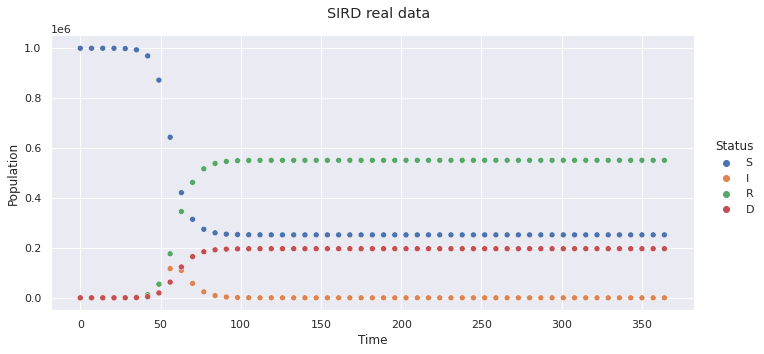

In [6]:
sns.set(rc={"figure.facecolor":"white"})
g = sns.relplot(data=data_real, x="time", y="population", hue="status", aspect=2)
g.set_axis_labels("Time", "Population")
g._legend.set_title("Status")
g.tight_layout(w_pad=1)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"SIRD real data")
# plt.savefig("SIRD_real.png", dpi=300)
plt.show()

## DINN

In [7]:
def dinn(data_t, data_y, N):    
    
    # Variables
    beta = tf.math.sigmoid(dde.Variable(0.1))
    omega = tf.math.sigmoid(dde.Variable(0.1))
    gamma = tf.math.sigmoid(dde.Variable(0.1))
    variable_list = [beta, omega, gamma]
    
    # ODE model
    def ODE(t, y):
        S = y[:, 0:1]
        I = y[:, 1:2]
        R = y[:, 2:3]
        D = y[:, 3:4]
        
        dS_t = dde.grad.jacobian(y, t, i=0)
        dI_t = dde.grad.jacobian(y, t, i=1)
        dR_t = dde.grad.jacobian(y, t, i=2)
        dD_t = dde.grad.jacobian(y, t, i=3)

        return [
            dS_t - (- beta / N * S * I),
            dI_t - (beta / N * S * I - gamma * I - omega * I),
            dR_t - (gamma * I),
            dD_t - (omega * I)
        ]
    
    # Geometry
    geom = dde.geometry.TimeDomain(data_t[0, 0], data_t[-1, 0])
    
    # Boundaries
    def boundary(_, on_initial):
        return on_initial
    
    # Initial conditions
    ic_S = dde.icbc.IC(geom, lambda x: N- 1, boundary, component=0)
    ic_I = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)
    ic_R = dde.icbc.IC(geom, lambda x: 0, boundary, component=2)
    ic_D = dde.icbc.IC(geom, lambda x: 0, boundary, component=3)

    # Train data
    observe_S = dde.icbc.PointSetBC(data_t, data_y[:, 0:1], component=0)
    observe_I = dde.icbc.PointSetBC(data_t, data_y[:, 1:2], component=1)
    observe_R = dde.icbc.PointSetBC(data_t, data_y[:, 2:3], component=2)
    observe_D = dde.icbc.PointSetBC(data_t, data_y[:, 3:4], component=3)
    
    # Model
    data = dde.data.PDE(
        geom,
        ODE,
        [
            ic_S,
            ic_I,
            ic_R,
            ic_D,
            observe_S,
            observe_I,
            observe_R,
            observe_D
        ],
        num_domain=400,
        num_boundary=2,
        anchors=data_t,
    )
    
    net = dde.nn.FNN([1] + [128] * 3 + [4], "relu", "Glorot uniform")
    
    def feature_transform(t):
        t = t / data_t[-1, 0]
        return t

    net.apply_feature_transform(feature_transform)

    iterations = 50000
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        loss_weights=4 * [1] + 4 * [1] + 4 * [1e1],
        external_trainable_variables=variable_list
    )
    variable = dde.callbacks.VariableValue(
        variable_list,
        period=5000,
        # filename="variables_sird.dat"
    )
    losshistory, train_state = model.train(
        iterations=iterations,
        display_every=10000,
        callbacks=[variable]
      )
    # dde.saveplot(losshistory, train_state, issave=True, isplot=True)
    return model, variable

In [8]:
model, variable = dinn(t, y, N)

Compiling model...
Building feed-forward neural network...
'build' took 0.043700 s



/home/aoguedao/mambaforge/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+402=402. 
  warnings.warn("The balance properties of Sobol' points require "
/home/aoguedao/mambaforge/envs/pinn/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-10-25 15:50:21.906124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-25 15:50:21.909066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] cou

'compile' took 2.162468 s

Initializing variables...


2022-10-25 15:50:24.041435: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-10-25 15:50:24.685769: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7fd0f40104d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-10-25 15:50:24.685808: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2022-10-25 15:50:24.871130: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-25 15:50:24.942594: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2022-10-25 15:50:25.030495: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [3.93e-08, 1.06e-03, 2.65e-04, 2.65e-04, 1.00e+12, 1.00e+00, 0.00e+00, 0.00e+00, 2.09e+12, 6.18e+09, 2.46e+12, 3.14e+11]    [3.93e-08, 1.06e-03, 2.65e-04, 2.65e-04, 1.00e+12, 1.00e+00, 0.00e+00, 0.00e+00, 2.09e+12, 6.18e+09, 2.46e+12, 3.14e+11]    []  
0 [5.25e-01, 5.25e-01, 5.25e-01]
5000 [1.74e-01, 5.96e-02, 5.64e-02]
10000     [8.56e+02, 3.36e+02, 9.83e+04, 3.94e+04, 2.67e+11, 5.99e+07, 1.92e+11, 2.44e+10, 6.45e+11, 5.57e+09, 4.91e+11, 6.26e+10]    [8.56e+02, 3.36e+02, 9.83e+04, 3.94e+04, 2.67e+11, 5.99e+07, 1.92e+11, 2.44e+10, 6.45e+11, 5.57e+09, 4.91e+11, 6.26e+10]    []  
10000 [7.28e-02, 1.72e-02, 1.37e-02]
15000 [5.28e-01, 8.83e-02, 2.67e-01]
20000     [7.89e+06, 1.56e+06, 2.67e+06, 5

## Postprocessing

In [9]:
parameter_names = [
  "beta",
  "omega",
  "gamma",
]
errors = (
    pd.DataFrame(
        {
            "real": parameters_real,
            "predicted": variable.value
        },
        index=parameter_names
    )
    .assign(
        relative_error=lambda x: (x["real"] - x["predicted"]).abs() / x["real"] * 100
    )
)
# errors.to_excel("SIRD_errors.xlsx")
errors

,real,predicted,relative_error
beta,0.500000,0.501169,0.233757
omega,0.071429,0.072030,0.841969
gamma,0.200000,0.200175,0.087471


In [10]:
full_t = np.arange(0, 366)[:, np.newaxis]
y_pred = model.predict(full_t)
data_pred = (
    pd.DataFrame(y_pred, columns=names, index=full_t.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status", value_name="population")
)
data_pred.head()

,time,status,population
0,0,S,1.000108e+06
1,1,S,1.000086e+06
2,2,S,1.000049e+06
3,3,S,1.000144e+06
4,4,S,1.000216e+06


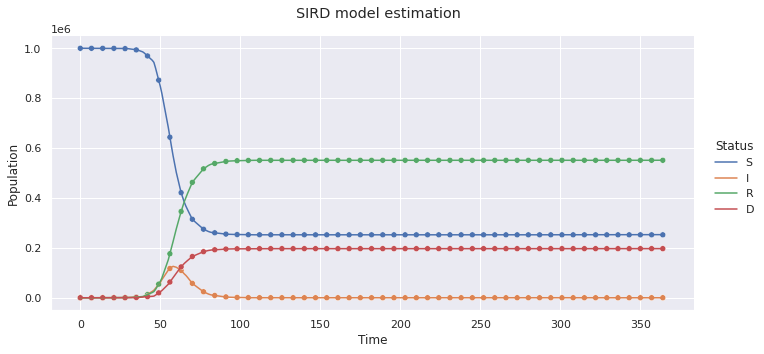

In [11]:
sns.set(rc={"figure.facecolor":"white"})

g = sns.relplot(
    data=data_pred,
    x="time",
    y="population",
    hue="status",
    kind="line",
    aspect=2,
)

sns.scatterplot(
    data=data_real,
    x="time",
    y="population",
    hue="status",
    ax=g.ax,
    legend=False
)


(
    g.set_axis_labels("Time", "Population")
      .set_titles("Zone {row_name}")
      .tight_layout(w_pad=1)
)

g._legend.set_title("Status")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"SIRD model estimation")
# plt.savefig("SIRD_estimation.png", dpi=300)
plt.show()

In [12]:
dde.metrics.l2_relative_error(y, model.predict(t))

2022-10-25 15:52:30.714817: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


0.00021556360117540595

In [13]:
dde.metrics.mean_squared_error(y, model.predict(t))

5660.3504041675305